### Inventory, class balance and file integrity

  Domain        Class  Count Sample_Resolution  Percentage
0  Walls      Cracked   3751           256x256   20.909750
1  Walls  Non-Cracked  14188           256x256   79.090250
2  Decks      Cracked   1926           256x256   14.349575
3  Decks  Non-Cracked  11496           256x256   85.650425


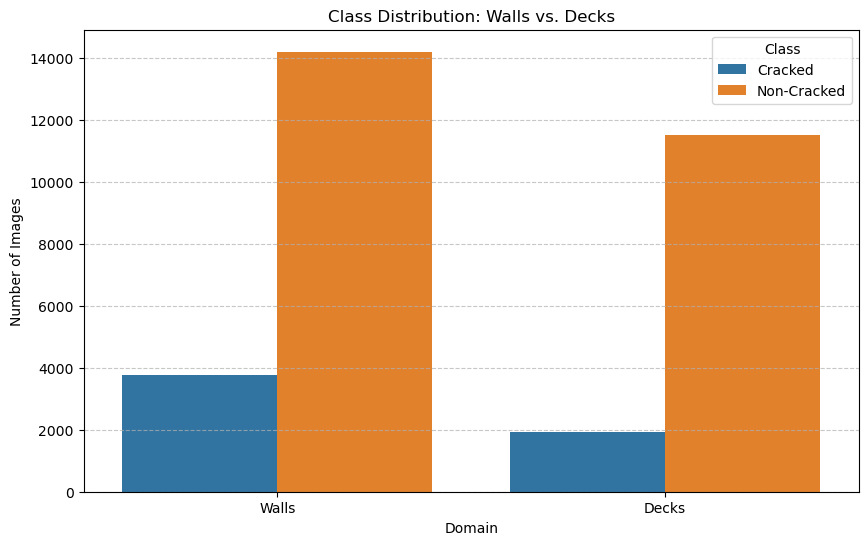

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define paths based on the project brief structure
data_dirs = { "Walls": "Training_Pool_A_Walls", "Decks": "Training_Pool_B_Decks"}
categories = ["Cracked", "Non-Cracked"]
stats = []

for domain, root_dir in data_dirs.items():
    for cat in categories:
        path = os.path.join(root_dir, cat)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Basic Integrity Check: Check first image for dimensions
            sample_size = "N/A"
            if files:
                with Image.open(os.path.join(path, files[0])) as img:
                    sample_size = f"{img.size[0]}x{img.size[1]}"
            
            stats.append({
                "Domain": domain,
                "Class": cat,
                "Count": len(files),
                "Sample_Resolution": sample_size
            })

# Convert to DataFrame for easy analysis
df_audit = pd.DataFrame(stats)

# Calculate Imbalance Ratios
df_audit['Percentage'] = df_audit.groupby('Domain')['Count'].transform(lambda x: (x / x.sum()) * 100)

print(df_audit)

# Visualizing Class Imbalance
plt.figure(figsize=(10, 6))
sns.barplot(data=df_audit, x='Domain', y='Count', hue='Class')
plt.title("Class Distribution: Walls vs. Decks")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Visual sampling 

Generate a grid of images for each category --> look for non-structural features that might confuse CNN --> observe visual differences between walls and decks 

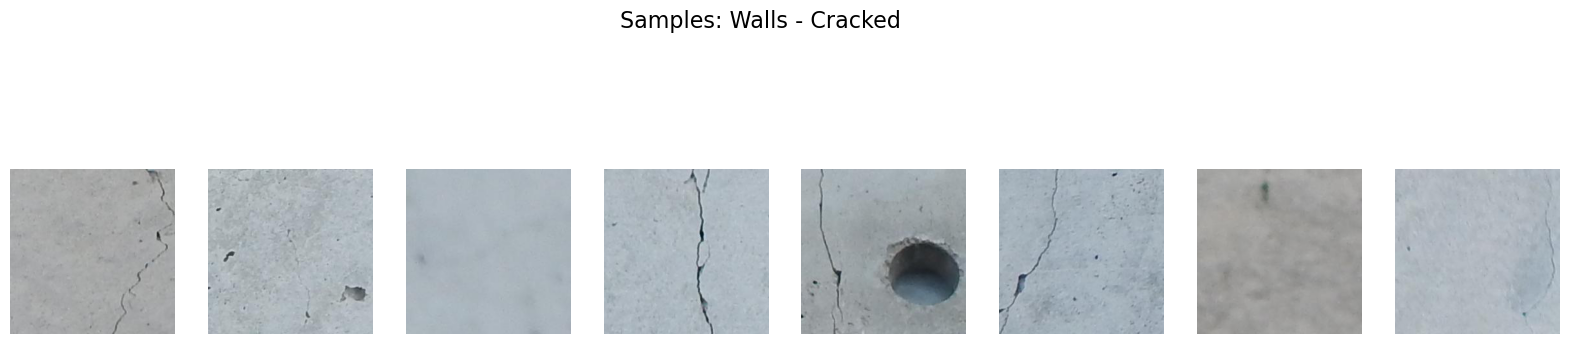

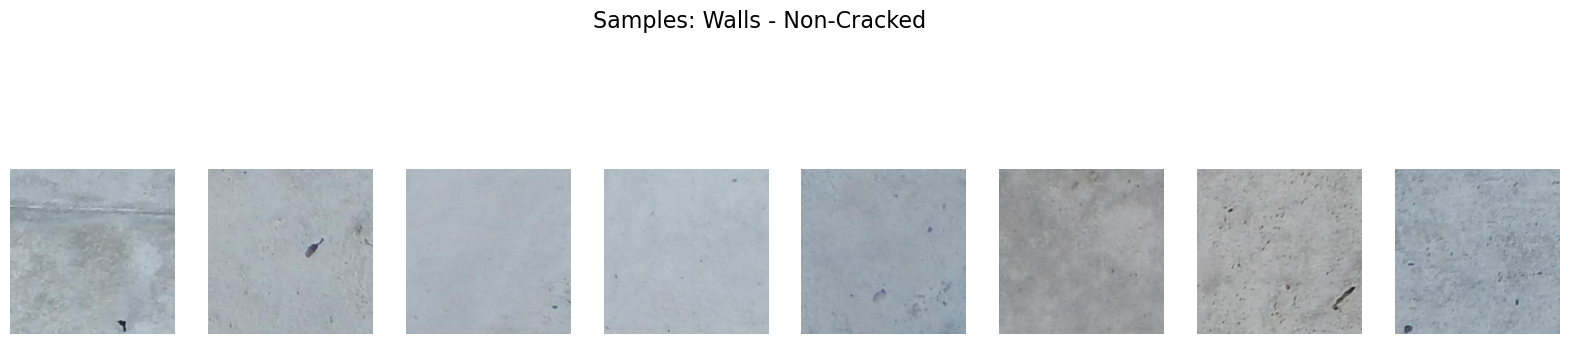

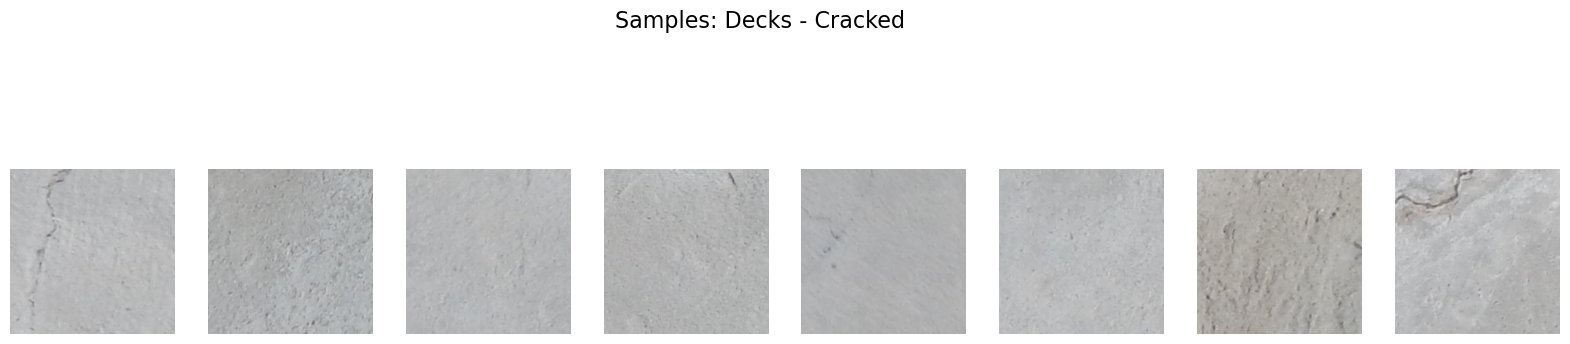

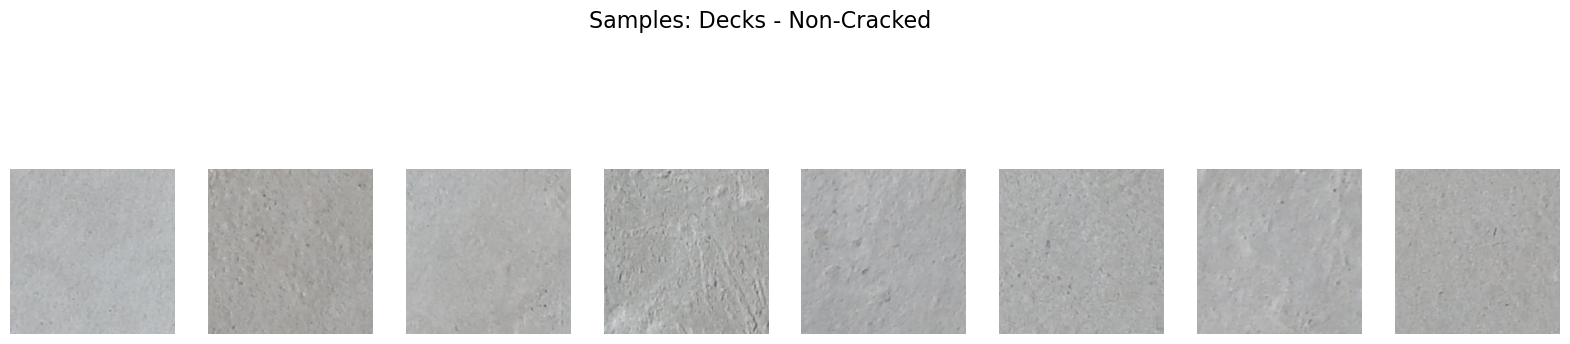

In [ ]:
import numpy as np
import random

def plot_category_samples(domain, category, num_samples=8):
    path = os.path.join(data_dirs[domain], category)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(files, num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    fig.suptitle(f"Samples: {domain} - {category}", fontsize=16)
    
    for i, file in enumerate(selected_files):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        # We can also print individual image stats if needed
    plt.show()

# Run for all combinations
for domain in data_dirs.keys():
    for cat in categories:
        plot_category_samples(domain, cat)


### Colour and luminance distribution analysis

- Calculate R,G,B, and Luminance for every image in the Training Pools

- Use data spread to see range of shadows and water stains

- Generate histograms


Processing 3751 images for Walls - Cracked...
Processing 14188 images for Walls - Non-Cracked...
Processing 1926 images for Decks - Cracked...
Processing 11496 images for Decks - Non-Cracked...


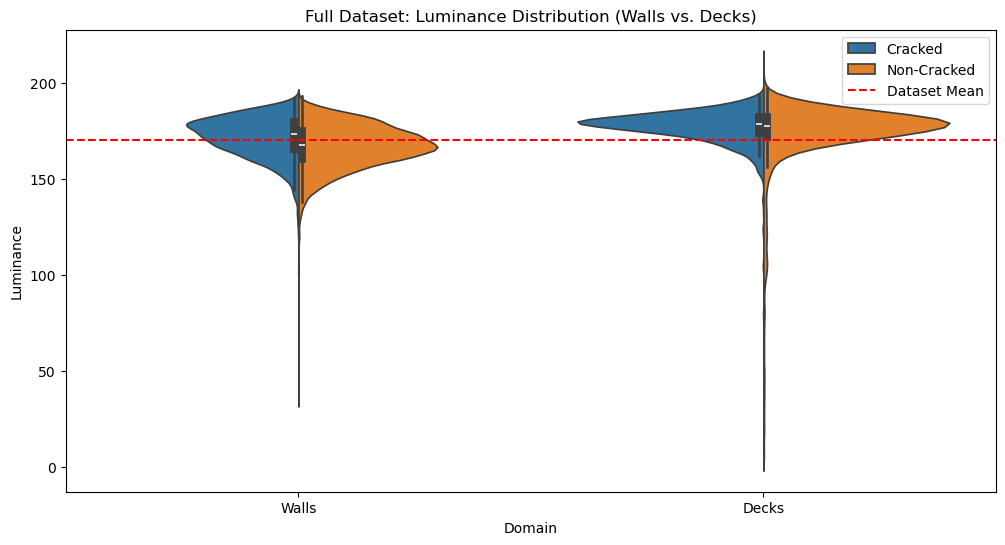

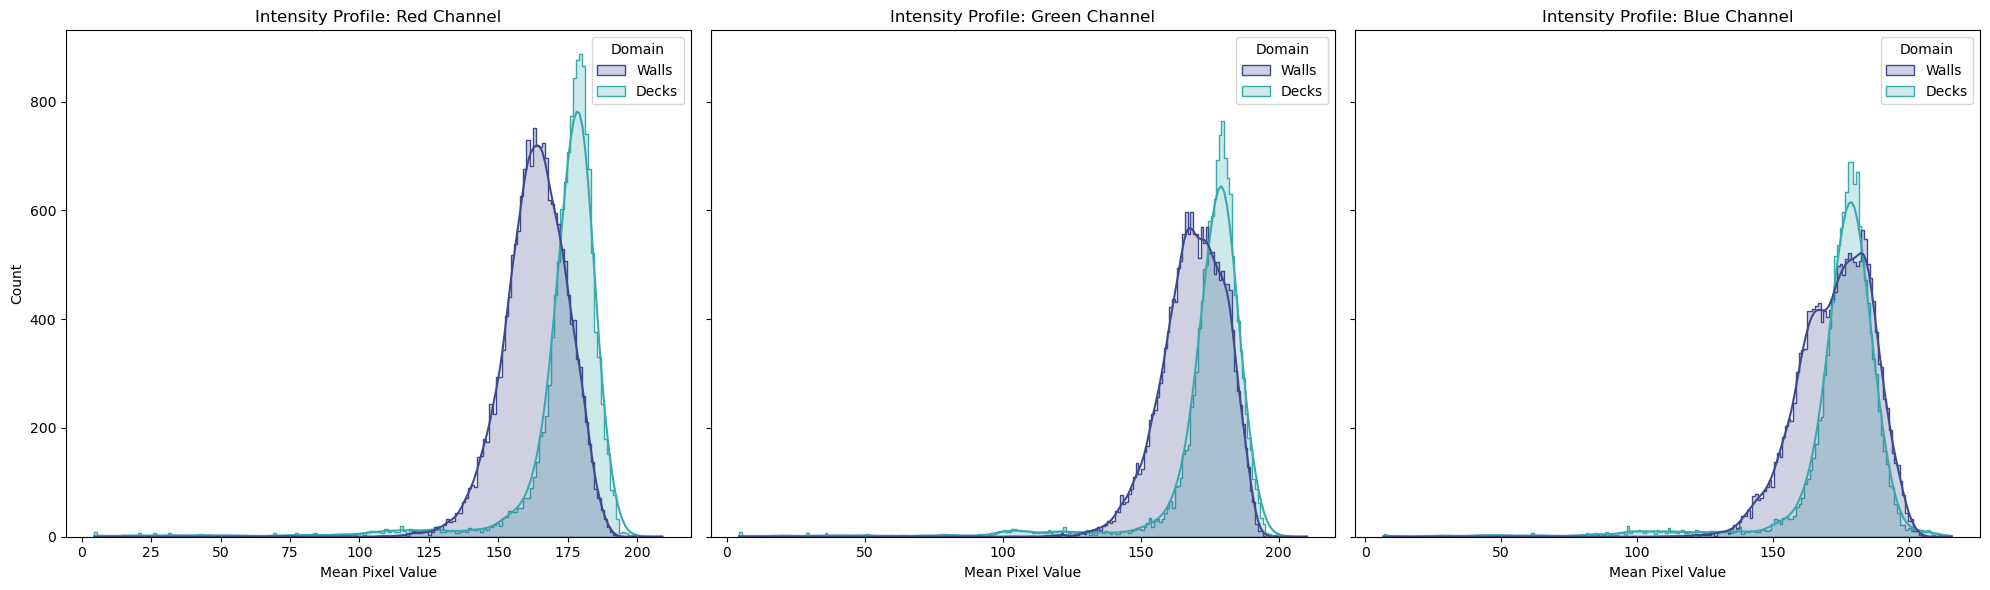


--- Summary Statistics (Full Dataset) ---
                      count        mean        std         min         25%  \
Domain Class                                                                 
Decks  Cracked       1926.0  177.276366   8.387583   79.161713  174.044754   
       Non-Cracked  11496.0  172.834299  21.095562    4.552597  171.702679   
Walls  Cracked       3751.0  171.621210  10.670145  102.021973  165.325615   
       Non-Cracked  14188.0  166.803113  11.469333   34.911087  160.115795   

                           50%         75%         max  
Domain Class                                            
Decks  Cracked      178.548836  182.257614  194.704269  
       Non-Cracked  177.419121  181.986343  210.127884  
Walls  Cracked      173.084427  179.591545  192.022995  
       Non-Cracked  167.380966  174.814404  193.123505  


In [ ]:
import cv2

def get_full_dataset_stats(domain, category):
    """
    Processes every image in the specified directory to extract 
    color and luminance statistics.
    """
    path = os.path.join(data_dirs[domain], category)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    means = []
    print(f"Processing {len(files)} images for {domain} - {category}...")
    
    for file in files:
        img_path = os.path.join(path, file)
        
        # Load image (OpenCV uses BGR by default)
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        # Convert to Gray for luminance statistics
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lum_mean = np.mean(gray)
        
        # Calculate mean for R, G, B (converting BGR to RGB logic)
        # Using mean(axis=(0,1)) is faster than calculating per channel manually
        b_mean, g_mean, r_mean = np.mean(img, axis=(0, 1))
        
        means.append([domain, category, r_mean, g_mean, b_mean, lum_mean])
        
    return means

# 1. Collect data from ALL images
all_stats = []
for domain in data_dirs.keys():
    for cat in categories:
        all_stats.extend(get_full_dataset_stats(domain, cat))

# 2. Convert to DataFrame
df_stats = pd.DataFrame(all_stats, columns=['Domain', 'Class', 'R_Mean', 'G_Mean', 'B_Mean', 'Luminance'])

# 3. Visualization: Full Dataset Luminance Distribution
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_stats, x='Domain', y='Luminance', hue='Class', split=True)
plt.title("Full Dataset: Luminance Distribution (Walls vs. Decks)")
plt.axhline(df_stats['Luminance'].mean(), color='red', linestyle='--', label='Dataset Mean')
plt.legend()
plt.show()

# 4. Visualization: Full Dataset RGB Histogram (The "Shape" of your data)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
channel_cols = ['R_Mean', 'G_Mean', 'B_Mean']
channel_names = ['Red', 'Green', 'Blue']
colors = ['#e74c3c', '#2ecc71', '#3498db']

for i, col in enumerate(channel_cols):
    sns.histplot(data=df_stats, x=col, hue='Domain', kde=True, 
                 element="step", palette='mako', ax=axes[i])
    axes[i].set_title(f'Intensity Profile: {channel_names[i]} Channel')
    axes[i].set_xlabel('Mean Pixel Value')

plt.tight_layout()
plt.show()

print("\n--- Summary Statistics (Full Dataset) ---")
print(df_stats.groupby(['Domain', 'Class'])['Luminance'].describe())

- Decks show higher mean luminance compared to walls 

- Non-cracked decks show big s.d. and very small min luminance --> presence of deep shadows or deep water stains

- RGB Intensity profiles show very similar peaks and distributions --> justification to convert to grayscale?

- Cracked images have slightly higher mean luminance


### Texture and edge density analysis 

Use canny edge detection on dataset to see if we can distinguish between structural cracks and environmental noise

Percentage of edge pixels in every image is calculated to determine if cracked imgs have higher edge density than non-cracked ones

Calculating Edge Density for 3751 images in Walls - Cracked...
Calculating Edge Density for 14188 images in Walls - Non-Cracked...
Calculating Edge Density for 1926 images in Decks - Cracked...
Calculating Edge Density for 11496 images in Decks - Non-Cracked...


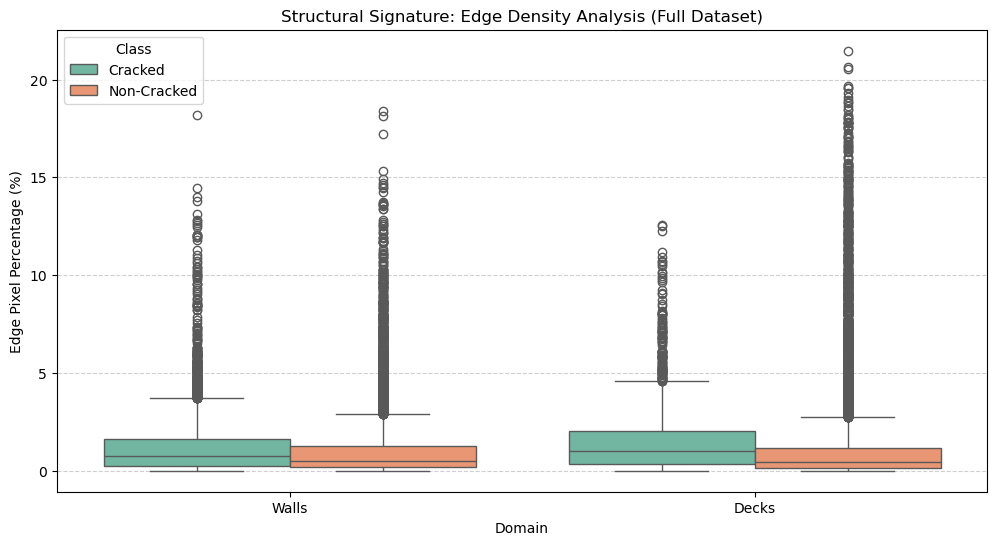


--- Edge Density Summary Statistics ---
                      count      mean       std  min       25%       50%  \
Domain Class                                                               
Decks  Cracked       1926.0  1.541188  1.766137  0.0  0.365067  1.011658   
       Non-Cracked  11496.0  1.233077  2.371697  0.0  0.135803  0.431824   
Walls  Cracked       3751.0  1.329452  1.756903  0.0  0.250244  0.747681   
       Non-Cracked  14188.0  1.056210  1.560040  0.0  0.172424  0.503540   

                         75%        max  
Domain Class                             
Decks  Cracked      2.050781  12.573242  
       Non-Cracked  1.176453  21.472168  
Walls  Cracked      1.634216  18.208313  
       Non-Cracked  1.269531  18.395996  


In [ ]:
def get_full_edge_density(domain, category):
    """
    Applies Canny edge detection to every image in the dataset to 
    calculate the density of high-frequency structural features.
    """
    path = os.path.join(data_dirs[domain], category)
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    edge_stats = []
    print(f"Calculating Edge Density for {len(files)} images in {domain} - {category}...")
    
    for file in files:
        img_path = os.path.join(path, file)
        
        # Load as grayscale directly for edge detection
        img = cv2.imread(img_path, 0)
        if img is None:
            continue
            
        # Apply Canny Edge Detection
        # Thresholds 100/200 are standard; can be tuned based on 'noise' findings
        edges = cv2.Canny(img, 100, 200)
        
        # Calculate density: (Number of edge pixels / Total pixels) * 100
        density = (np.sum(edges > 0) / (img.shape[0] * img.shape[1])) * 100
        edge_stats.append([domain, category, density])
        
    return edge_stats

# 1. Collect Edge Data from ALL images
edge_results = []
for domain in data_dirs.keys():
    for cat in categories:
        edge_results.extend(get_full_edge_density(domain, cat))

# 2. Convert to DataFrame
df_edges = pd.DataFrame(edge_results, columns=['Domain', 'Class', 'Edge_Density'])

# 3. Visualization: Edge Density Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_edges, x='Domain', y='Edge_Density', hue='Class', palette="Set2")
plt.title("Structural Signature: Edge Density Analysis (Full Dataset)")
plt.ylabel("Edge Pixel Percentage (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 4. Detailed Summary of Edge Distributions
print("\n--- Edge Density Summary Statistics ---")
print(df_edges.groupby(['Domain', 'Class'])['Edge_Density'].describe())

- cracked images show higher median edge density but IQR overlap significantly

- non-cracked decks contains extreme outliers e.g. 21.47%

- decks show slightly higher overall edge density than walls

- edge detection alone wont be useful for CNN 